# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [3]:
download_utils.link_all_keras_resources()

In [7]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import keras_utils

1.12.0
2.2.4


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [ ]:
grader = grading.Grader(assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
                        all_parts=["wuwwC", "a4FK1", "qRsZ1"])

In [ ]:
# token expires every 30 min
COURSERA_TOKEN = ### YOUR TOKEN HERE
COURSERA_EMAIL = ### YOUR EMAIL HERE

# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [6]:
# we downloaded them for you, just link them here
download_utils.link_week_3_resources()

# Prepare images for model

In [9]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [8]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [10]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    
    cropped_img = None### YOUR CODE HERE
    h, w, _ = img.shape
    if h==w:
        cropped_img = img
    if h > w:
        start_index = (h-w)//2
        cropped_img = img[start_index:start_index+w,:,:]
    if w > h:
        start_index = (w-h)//2
        cropped_img = img[:, start_index:start_index+h, :]
    
    return cropped_img

In [11]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [12]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


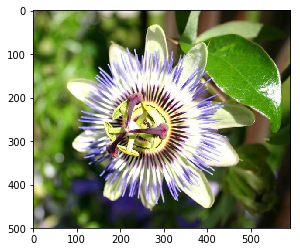

(250, 250, 3)


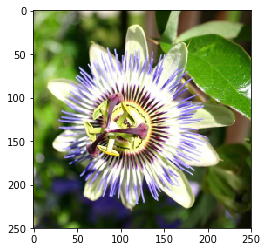

In [13]:
# test cropping
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Test image preparation for model
prepared_img = prepare_raw_bytes_for_model(read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg"))
grader.set_answer("qRsZ1", list(prepared_img.shape) + [np.mean(prepared_img), np.std(prepared_img)])

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

# Prepare for training

In [14]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [15]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [16]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [27]:
def gen_number():
    print('start at the function')
    lis = list(range(10))
    for i in lis:
        yield i*i
        print('inside for loop')
#     yield lis
    #yield 2
    print('outside for loop')
    
gen_number()

<generator object gen_number at 0x000001D4E1165F68>

In [28]:
for square_num in gen_number():
    print(square_num)

start at the function
0
inside for loop
1
inside for loop
4
inside for loop
9
inside for loop
16
inside for loop
25
inside for loop
36
inside for loop
49
inside for loop
64
inside for loop
81
inside for loop
outside for loop


In [31]:
# batch generator
# BATCH_SIZE = 32

# def batch_generator(items, batch_size):
#     """
#     Implement batch generator that yields items in batches of size batch_size.
#     There's no need to shuffle input items, just chop them into batches.
#     Remember about the last batch that can be smaller than batch_size!
#     Input: any iterable (list, generator, ...). You should do `for item in items: ...`
#         In case of generator you can pass through your items only once!
#     Output: In output yield each batch as a list of items.
#     """
    
#     ### YOUR CODE HERE
#     item_batches = []
#     num_batches = len(items) // batch_size
#     start_index = 0
#     for _ in range(num_batches):
#         item_batches.append(items[start_index:start_index+batch_size])
#         start_index = start_index+batch_size
#     if len(items)%batch_size != 0:
#         item_batches.append(items[start_index:])
#     for batch in item_batches:
#         yield batch

In [33]:
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
    Output: In output yield each batch as a list of items.
    """
    
    ### YOUR CODE HERE
    count = 0
    output = []
    for item in items:
        output.append(item)
        count += 1
        if count == batch_size:
            yield output
            output = []
            count = 0
    yield output

In [34]:
## GRADED PART, DO NOT CHANGE!
# Test batch generator
def _test_items_generator():
    for i in range(10):
        yield i

# grader.set_answer("a4FK1", list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3))))
list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3)))

[3, 3, 3, 1]

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

In [35]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)


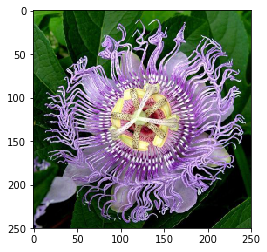

In [36]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [37]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [38]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [39]:
model = inception()

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 28, 28, 256)  0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 28, 28, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 28, 28, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 28, 28, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 28, 28, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 28, 28, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 28, 28, 64)   0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, 13, 13, 128)  384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 13, 13, 128)  0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 13, 13, 128)  0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 13, 13, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 13, 13, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 13, 13, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 13, 13, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 13, 13, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 13, 13, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 13, 13, 192)  0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, 13, 13, 192)  0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 13, 13, 768)  0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 13, 13, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 13, 13, 192)  576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, 13, 13, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 13, 13, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 13, 13, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 13, 13, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 13, 13, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, 6, 6, 384)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 6, 6, 192)    576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 6, 6, 320)    0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 6, 6, 768)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 6, 6, 768)    0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 102)          208998      global_average_pooling2d_1[0][0] 
Total params: 22,011,782
Trainable params: 21,977,350
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [41]:
# how many layers our model has
print(len(model.layers))

313


In [42]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [43]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [45]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 10
# model = load_model(model_filename.format(last_finished_epoch))

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [46]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(), 
               keras_utils.ModelSaveCallback(model_filename)],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Epoch 1/16


A Jupyter Widget


Model saved in flowers.000.hdf5
Epoch 2/16


A Jupyter Widget


Model saved in flowers.001.hdf5
Epoch 3/16


A Jupyter Widget


Model saved in flowers.002.hdf5
Epoch 4/16


A Jupyter Widget


Model saved in flowers.003.hdf5
Epoch 5/16


A Jupyter Widget


Model saved in flowers.004.hdf5
Epoch 6/16


A Jupyter Widget


Model saved in flowers.005.hdf5
Epoch 7/16


A Jupyter Widget


Model saved in flowers.006.hdf5
Epoch 8/16


A Jupyter Widget


Model saved in flowers.007.hdf5
Epoch 9/16


A Jupyter Widget


Model saved in flowers.008.hdf5
Epoch 10/16


A Jupyter Widget


Model saved in flowers.009.hdf5
Epoch 11/16


A Jupyter Widget

KeyboardInterrupt: 

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
grader.set_answer("wuwwC", test_accuracy)
print(test_accuracy)

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model